# Schematic Driven layout

The Schematic driven layout uses a schematic format similar to our `*.pic.yml`.

The Jupyter notebook interface allows you to get the best of both worlds of GUI and python driven based flows.

In [1]:
from bokeh.io import output_notebook

import gdsfactory as gf
from gdsfactory.schematic_editor import SchematicEditor
from gdsfactory.config import rich_output

%env BOKEH_ALLOW_WS_ORIGIN=localhost:8888

output_notebook()
rich_output()

2023-01-22 16:12:36.682 | INFO     | gdsfactory.config:<module>:50 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.23.4


2023-01-22 16:12:37.519 | INFO     | gdsfactory.technology.layer_views:__init__:779 - Importing LayerViews from KLayout layer properties file: /home/runner/work/gdsfactory/gdsfactory/gdsfactory/generic_tech/klayout/tech/layers.lyp.


env: BOKEH_ALLOW_WS_ORIGIN=localhost:8888


Loading BokehJS ...

First you initialize a session of the schematic editor.
The editor is synced to a file.
If file exist, it loads the schematic for editing. If it does not exist, it creates it.
The schematic file is continuously auto-saved as you edit the schematic in your notebook, so you can track changes with GIT.

In [2]:
se = SchematicEditor("test.schem.yml")

## Define instances

First you need to define which instances to include. We do this through this grid-like editor.
Components are auto-populated from your active PDK.

instance name | Component type
--------------| --------------
mmi1          | mmi1x2

In [3]:
se.instance_widget

In [4]:
se.instances.keys()

dict_keys(['mmi1', 'mmi2', 's1', 's2'])

You can also **add your instances through code**, and since it is just a dictionary update, *the integrity of your schematic will be maintained, even after re-running the notebook* as-is.
You can here specify a component either by name or as an actual component, using auto-completion to specify your settings as well.

In [5]:
se.add_instance("s1", gf.components.straight(length=20))
se.add_instance("s2", gf.components.straight(length=40))

But you can even query the parameters of default components, set only by name through the widget grid, like so:

In [6]:
se.instances["mmi1"].settings.full

{
    'width': None,
    'width_taper': 1.0,
    'length_taper': 10.0,
    'length_mmi': 5.5,
    'width_mmi': 2.5,
    'gap_mmi': 1.0,
    'taper': {'function': 'taper'},
    'with_bbox': True,
    'cross_section': 'strip'
}

It is also possible to *instantiate through the widget, then set the settings of our component later, through code.*

By doing this through code, we have the full power of python at our disposal to easily use shared variables between components, or set complex Class or dictionary-based settings, without fumbling through a UI.

In [7]:
se.update_settings("mmi1", gap_mmi=1.0)
se.update_settings("mmi2", gap_mmi=0.7)

for inst_name, inst in se.instances.items():
    if inst.settings.changed:
        print(f"{inst_name}: {inst.settings.changed}")

mmi1: {'gap_mmi': 1.0}
mmi2: {'gap_mmi': 0.7}
s1: {'length': 20}
s2: {'length': 40}


## Define nets

Now, you define your logical connections between instances in your netlist. Each row in the grid represents one logical connection.

In [8]:
se.net_widget

Similarly, you can programmatically add nets.
Adding a net which already exists will have no effect, such that the notebook can be rerun without consequence.
However, trying to connect to a port which is already otherwise connected will throw an error.

In [9]:
se.add_net(
    inst1="mmi1", port1="o2", inst2="s1", port2="o1"
)  # can be re-run without consequence
se.add_net(inst1="s1", port1="o1", inst2="mmi1", port2="o2")  # also ok
# se.add_net(inst1="s1", port1="o2", inst2="mmi1", port2="o2")  # throws error -- already connected to a different port

In [10]:
se.schematic

SchematicConfiguration(
    instances={
        'mmi1': Instance(component='mmi1x2', settings={'gap_mmi': 1.0}),
        'mmi2': Instance(component='mmi2x2', settings={'gap_mmi': 0.7}),
        's1': Instance(component='straight', settings={'length': 20}),
        's2': Instance(component='straight', settings={'length': 40})
    },
    schematic_placements={
        'mmi1': Placement(
            x=None,
            y=None,
            port=None,
            rotation=0.0,
            dx=-22.832156230736544,
            dy=-0.9358105716724547,
            mirror=None
        ),
        'mmi2': Placement(
            x=None,
            y=None,
            port=None,
            rotation=0.0,
            dx=130.94675850281985,
            dy=-0.39903161225107286,
            mirror=None
        ),
        's1': Placement(
            x=None,
            y=None,
            port=None,
            rotation=0.0,
            dx=55.26042176045793,
            dy=32.1189871057287,
            mirror=None
        ),
        's2': Placement(
            x=None,
            y=None,
            port=None,
            rotation=0.0,
            dx=44.25454877902524,
            dy=-45.88086750118762,
            mirror=None
        )
    },
    nets=[['mmi1,o2', 's1,o1'], ['mmi2,o2', 's1,o2'], ['mmi1,o3', 's2,o1'], ['mmi2,o1', 's2,o2']],
    ports={'o1': 'mmi1,o1', 'o2': 'mmi2,o3', 'o3': 'mmi2,o4'}
)

## Define ports

Now, you define the Component ports following the syntax 

PortName | InstanceName,PortName

In [11]:
se.port_widget

## Visualize

You can visualize your schematic down below. After you've initialized the plot below, you should see it live-update after every change we make above.

Currently the size of component symbols and port locations are **layout-realistic**.
This may be a nice default if you don't care to bother making symbols for your components.
But it would be a nice improvement for the future to allow associating symbols with components, to make the schematic easier to read.

If you activate the `Point Draw Tool` in the plot, you should see that you are able to arrange components freely on the schematic, and changes are saved back to the `*.schem.yml` file in realtime.

![pointdraw](https://i.imgur.com/mlfsd13.png)

In [12]:
se.visualize()

layer (0, 0) not found
layer (0, 0) not found
layer (0, 0) not found
layer (0, 0) not found


## generate Layout

You can use your schematic to generate a preliminary layout, and view in the notebook and/or KLayout. Initial placements come from schematic placements and Routes are auto-generated from nets.

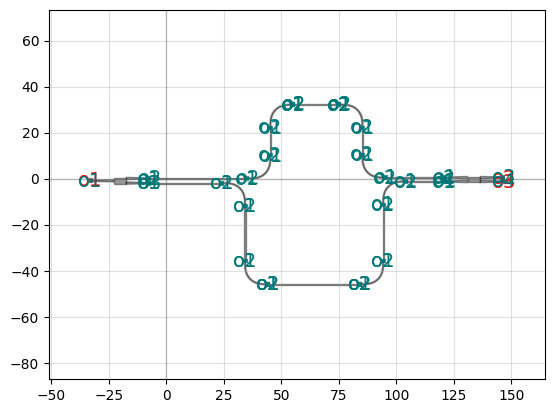

In [13]:
layout_filename = "sdl_demo.pic.yml"
se.instantiate_layout(layout_filename, default_router="get_bundle")
c = gf.read.from_yaml(layout_filename)
f = c.plot()

In [14]:
# you can save your schematic to a standalone html file once you are satisfied
# se.save_schematic_html('demo_schem.html')

## Circuit simulations

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import gdsfactory.simulation.sax as gs
import jax.numpy as jnp
import sax

netlist = c.get_netlist()

models = {
    "bend_euler": gs.models.bend,
    "mmi1x2": gs.models.mmi1x2,
    "mmi2x2": gs.models.mmi2x2,
    "straight": gs.models.straight,
}

circuit, _ = sax.circuit(netlist=netlist, models=models)

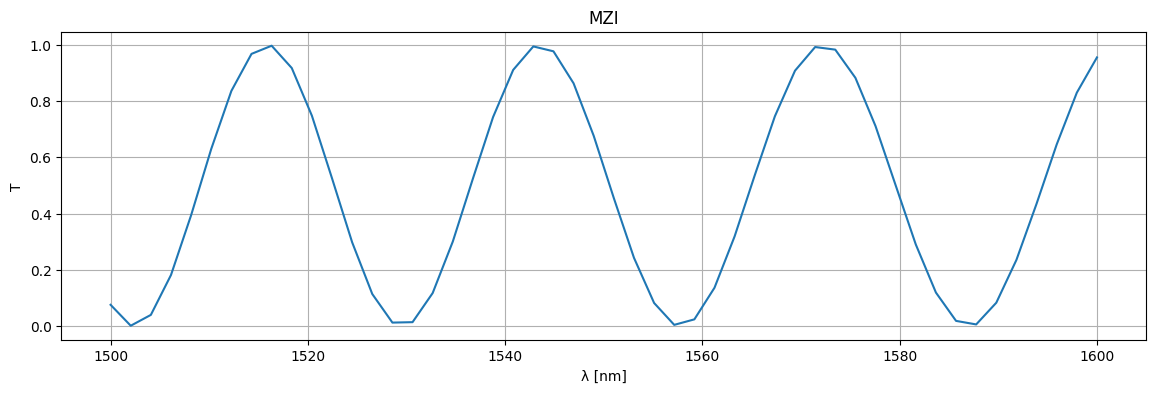

In [16]:
wl = np.linspace(1.5, 1.6)
S = circuit(wl=wl)

plt.figure(figsize=(14, 4))
plt.title("MZI")
plt.plot(1e3 * wl, jnp.abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.show()